# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 



In [ ]:
!pip install --upgrade pip
!pip install -U somoclu
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install numpy --upgrade --ignore-installed
!pip install -U gensim

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd
import numpy as np
import nltk as nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import joblib
import somoclu
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 100

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', 
              expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
def print_synopsis(text,line_len=100):
  """
   Συνάρτηση που εκτυπώνει την σύνοψη μίας ταινίας, σε πλήρη στοίχιση και κάθε γραμμή
   έχει πλήθος χαρακτήρων ίσο με line_len
  """
  words = text.split()
  temp = []
  length = 0
  for w in words:
    length += len(w)+1
    if(length <= line_len):
      temp.append(w)
    else:
      length += - len(w) -2
      i = 0
      while(length < line_len):
        temp[i] = temp[i]+' '
        i +=1
        length +=1
      sen = ' '.join(temp)
      print(sen)  
      length = len(w)+1
      temp = []
      temp.append(w)
  sen = ' '.join(temp)
  print(sen)
  return

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID],'\n')
print_synopsis(corpus[ID])

['Parasomnia']
['"Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Suspense",  "Slasher"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το **lemmatization**.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
stop_words = set(stopwords.words('english')) # Εισαγωγή stop words από την αγγλική γλώσσα
                                             # Λογικά θα χρειαστεί προσθήκη δικών μας stop words !!!

lemmatizer = WordNetLemmatizer() # lemmatization 
word_tokens=[]
token = RegexpTokenizer(r'\w+')  # Θα το χρησιμοποιήσουμε για να αφαιρέσουμε σημεία στίξης από το corpus 
final=[]
Corp = corpus.copy()

for i in range(0,len(corpus)):
  filter=[]
  filtered = []
  Corp[i]=Corp[i].lower()  # Μετατροπή όλων των γραμμάτων σε πεζά
  temp = word_tokenize(Corp[i]) # Τοποθετούμε στην μεταβλητή temp, τις επιμέρους λέξεις σε μορφή λίστας
  word_tokens.append(temp) 

  for w in range(0,len(temp)):  # Αφαίρεση των stop words από τα corpus
    if not temp[w] in stop_words:
      filtered.append(lemmatizer.lemmatize(temp[w]))

  filter = ' '.join(filtered)
  filtered = token.tokenize(filter)  # Αφαίρεση των κανονικών εκφράσεων (+ σημεία στίξης)

  indexes = np.unique(filtered,return_index=True)[1]  # Αφαίρεση όσων λέξεων επαναλαμβάνονται πολλές φορές 
  filtered = [filtered[index] for index in sorted(indexes)] 

  final.append(filtered)

In [ ]:
print(final[99][:15])

['young', 'artist', 'reno', 'miller', 'girlfriend', 'carol', 'enter', 'catholic', 'church', 'approach', 'elderly', 'bearded', 'man', 'kneeling', 'pulpit']


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
for b in range(0, 5000):
    words = TreebankWordDetokenizer().detokenize(final[b])
    final[b]=words

In [ ]:
print(final[999])

danny sloan art student work record shop visit friend billy drug rehab hospital suggests go see psycho ward leaf byron volpe serial killer kept padded cell convicted murdering wife madeline hypnotizing jumping building explained extraordinary power hypnotism restrained hooded stop staff seeing eye laura baxter sleeping room next suffers form parasomnia sleep time wake occasionally short period fall love continues find due move clinic run dr bhyle used medical experimentation resolve rescue disguised doctor kidnaps take apartment following morning discovers neighbor murdered attack knife seemingly trance detective conroy investigating s death come kill decides must controlling buy handgun overpowers escape derelict book garrett speaks phone control set repeatedly playing russian roulette explains rather make forget hypnotizes denouncing sound gunshot made shooting break spell fight finally defeat wounded shoot side head rendering comatose film end cared together corso back casting direc

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(final)
corpus_tf_idf_plain = vectorizer.transform(final)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
print(corpus_tf_idf_plain.shape)

(5000, 44463)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
def get_dis(elem):
  return elem[1]

def movie_info(target_movie):
  
  ## Εκτύπωση των στοιχείων της ταινίας στόχου 
  print('Movie ID:',target_movie)
  print("Movie Name:",*titles[target_movie])
  print('Catergories:',', '.join(categories[target_movie]))
  cstr = "        Movie Recap       "
  print ('\n<{0}>\n'.format(cstr.center(148, '-')))
  print_synopsis(corpus[target_movie],150)
  return

def content_recommender (target_movie,corpus_type,max_recommendations = 10):

  movie_info(target_movie)

  ## Υπολογισμός της ομοιότητας συνημιτόνου με τις υπόλοιπες ταινίες του dataset

  cossim = []
  ids = np.arange(0,len(corpus),1)
  for id in range(np.shape(corpus_type)[0]):
    sim = cosine_similarity(corpus_type[target_movie].toarray(),corpus_type[id].toarray())
    cossim.append(sim.item())   

  ## Ταξινόμηση των στοιχείων κατά αύξουσα σειρά και αποθήκευση όσων θέλουμε (μεταβλητή max_recommendations)

  cossim = list(zip(ids,cossim))
  cossim.sort(key=get_dis,reverse=True)
  res = cossim[1:max_recommendations+1]
  return res

In [ ]:
h = content_recommender(999,corpus_tf_idf_plain,max_recommendations = 3)

Movie ID: 999
Movie Name: Parasomnia
Catergories: "Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Suspense",  "Slasher"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Danny  Sloan is an art student who works in a record shop. He visits his friend Billy , who is in drug rehab in hospital. Billy suggests Danny goes to
see  the  "psycho  ward"  before  he  leaves,  to  see Byron Volpe , a serial killer kept in a padded cell after being convicted of murdering his wife
Madeline  by  hypnotizing  her  into jumping from a building. Volpe is explained to have extraordinary powers of hypnotism, and is kept restrained and
hooded  to  stop hospital staff from seeing his eyes. During the visit, Danny sees Laura Baxter sleeping in the room next to Volpe. She suffers from a
form  of  parasomnia  in  which  she  sleeps  most  of the time, and wakes occasionally for short peri

In [ ]:
for i,m_info in enumerate(h,1):
  print('Information about recommended movie No{0} with cosine similarity score: {1:.4f} %'.format(i,m_info[1]*100))
  movie_info(m_info[0])
  print('\n')

Information about recommended movie No1 with cosine similarity score: 9.2015 %
Movie ID: 3049
Movie Name: Sleeping Bride
Catergories: "Drama",  "Romance Film",  "Fantasy",  "Japanese Movies"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

On  March  13,  1954, a passenger plane crashes in Japan, killing all but one passenger: a woman who is nine months pregnant. Ultimately she dies in a
hospital,  but  her  unborn  daughter  is  saved.  However,  for a reason inexplicable by the science of the day, the daughter does not wake up and is
essentially  in a comatose state. Her wealthy father has her placed in a hospital where she will be cared for indefinitely while he vanishes in search
of  a  cure to her condition. Seven years later Yuichi is admitted to the same hospital and discovers Yumi. After being told of her condition and then
reading  the  story  of Sleeping Beauty, he resolves

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [ ]:
vectorizer_opt = TfidfVectorizer()
vectorizer_opt.max_df=250
vectorizer_opt.stop_words='english'
vectorizer_opt.max_features=8000

vectorizer_opt.fit(final)
corpus_opt_tf_idf_plain = vectorizer_opt.transform(final)

print(corpus_opt_tf_idf_plain.shape)

(5000, 8000)


In [ ]:
h1 = content_recommender(999,corpus_opt_tf_idf_plain,max_recommendations = 3)

Movie ID: 999
Movie Name: Parasomnia
Catergories: "Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Suspense",  "Slasher"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Danny  Sloan is an art student who works in a record shop. He visits his friend Billy , who is in drug rehab in hospital. Billy suggests Danny goes to
see  the  "psycho  ward"  before  he  leaves,  to  see Byron Volpe , a serial killer kept in a padded cell after being convicted of murdering his wife
Madeline  by  hypnotizing  her  into jumping from a building. Volpe is explained to have extraordinary powers of hypnotism, and is kept restrained and
hooded  to  stop hospital staff from seeing his eyes. During the visit, Danny sees Laura Baxter sleeping in the room next to Volpe. She suffers from a
form  of  parasomnia  in  which  she  sleeps  most  of the time, and wakes occasionally for short peri

In [ ]:
for i,m_info in enumerate(h1,1):
  print('Information about recommended movie No{0} with cosine similarity score: {1:.4f} %'.format(i,m_info[1]*100))
  movie_info(m_info[0])
  print('\n')

Information about recommended movie No1 with cosine similarity score: 11.7171 %
Movie ID: 2352
Movie Name: Stark Raving Mad
Catergories: "Drama"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

The  film  opens  with convicted serial killer Richard Stark on death row and awaiting execution. While he waits in the death cell he begins to relate
the story of the circumstances that led to his present situation.


Information about recommended movie No2 with cosine similarity score: 11.4098 %
Movie ID: 3746
Movie Name: Cahill U.S. Marshal
Catergories: "Action/Adventure",  "Western",  "Action"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

While  Cahill  is  away,  his  two sons Danny and Billy aid bank robber Fraser and his gang. When Cahill returns, he and Comanche Lightfoot pursue t

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
model = gensim.downloader.load("word2vec-google-news-300")

[=================================================-] 99.9% 1661.6/1662.8MB downloaded


In [ ]:
model2 = gensim.downloader.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
print(model.most_similar('thriller'))
print(model['thriller'].shape)

[('thrillers', 0.7824050188064575), ('suspense_thriller', 0.744051456451416), ('psychological_thriller', 0.725502073764801), ('spy_thriller', 0.716500461101532), ('thriller_starring', 0.6966468095779419), ('espionage_thriller', 0.669083833694458), ('supernatural_thriller', 0.6546312570571899), ('drama', 0.6441255211830139), ('potboiler', 0.6434439420700073), ('horror_thriller', 0.6433017253875732)]
(300,)


In [ ]:
print(model2.most_similar('thriller'))
print(model2['thriller'].shape)

[('horror', 0.8050946593284607), ('drama', 0.8046153783798218), ('sci-fi', 0.7875277400016785), ('spoof', 0.7765206098556519), ('comedy', 0.7700681090354919), ('movie', 0.7591501474380493), ('thrillers', 0.7583683729171753), ('film', 0.7575449347496033), ('fantasy', 0.7551495432853699), ('science-fiction', 0.7451509237289429)]
(50,)


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
def build_tfw2v(vectors,embeddings_size,corpus):

  # Υπολογισμός των tfidf τιμών των λέξεων του προεπεξεργασμένου dataset
  # Θα χρησιμοποιήσουμε τις ίδιες υπερ - παραμέτρους με την βελτιστοποιημένη 
  # έκδοση του TfidfVectorizer()

  vectorizer_op = TfidfVectorizer()
  vectorizer_op.max_df = 250
  vectorizer_op.stop_words = 'english'
  vectorizer_op.max_features = 8000
  vectorizer_op.fit(corpus)
  corpus_tf_idf = vectorizer_op.transform(corpus)
  
  # Δημιουργία πίνακα (5000 * m) που θ' αποθηκευτεί το νέο corpus
  x = len(corpus)           
  corp = np.zeros((x,embeddings_size))

  #Υλοποίηση παρονομαστή & αριθμητή με βάση τον παραπάνω τύπο
  temp=0
  for i in final:  
    movie_tokens = [token for token in word_tokenize(i)]  #παίρνουμε τα tokens ανά ταινία
    ar = np.zeros(embeddings_size)                        #αρχικοποιήση αριθμητή
    par = 0                                               #αρχικοποιήση παρονομαστή
    
    for w in movie_tokens:
       if w in vectorizer_op.vocabulary_:        #ελέγχουμε να δούμε αν υπάρχει η συγκεκριμένη λέξη στα tokens
         index = vectorizer_op.vocabulary_[w]     
         tfidf = corpus_tf_idf[temp,index]       #βρίσκουμε την τιμή της λέξης στο διάνυσμα tfidf της σχετικής ταινίας
         
         if w in vectors.index_to_key:      #ελέγχουμε να δούμε αν υπάρχει η λέξη στα προεκπαιδευμένα στοιχεία
           ar += vectors[w]*tfidf           #αθροισμα όρων αριθμητή
           par +=tfidf                      #άθροισμα όρων παρονομαστή
       else:
          continue
    
    corp[temp,:] += (ar/par)
    temp = temp + 1
  return csr_matrix(corp)

In [ ]:
tfw2v_corp = build_tfw2v(vectors=model,embeddings_size = 300,corpus=final)
tfw2v_corp.shape

(5000, 300)

In [ ]:
h2 = content_recommender(999,tfw2v_corp,max_recommendations=3)

Movie ID: 999
Movie Name: Parasomnia
Catergories: "Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Suspense",  "Slasher"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Danny  Sloan is an art student who works in a record shop. He visits his friend Billy , who is in drug rehab in hospital. Billy suggests Danny goes to
see  the  "psycho  ward"  before  he  leaves,  to  see Byron Volpe , a serial killer kept in a padded cell after being convicted of murdering his wife
Madeline  by  hypnotizing  her  into jumping from a building. Volpe is explained to have extraordinary powers of hypnotism, and is kept restrained and
hooded  to  stop hospital staff from seeing his eyes. During the visit, Danny sees Laura Baxter sleeping in the room next to Volpe. She suffers from a
form  of  parasomnia  in  which  she  sleeps  most  of the time, and wakes occasionally for short peri

In [ ]:
for i,m_info in enumerate(h2,1):
  print('Information about recommended movie No{0} with cosine similarity score: {1:.4f} %'.format(i,m_info[1]*100))
  movie_info(m_info[0])
  print('\n')

Information about recommended movie No1 with cosine similarity score: 88.8100 %
Movie ID: 630
Movie Name: A Nightmare on Elm Street 3: Dream Warriors
Catergories: "Horror",  "Slasher",  "Teen",  "Supernatural"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Six  years  after the events of the first film, Kristen Parker makes a replica of a house on Elm Street. While she is asleep she dreams about a little
girl  outside  the  house. When Kristen wakes up and goes to the bathroom she finds she is still asleep and encounters Freddy Krueger, who slashes her
wrists  with  the  razors on his glove. When Kristen awakes, she is holding a razor blade to her wrist. Her mother mistakes this incident as a suicide
attempt  and  places  Kristen  in  Westin  Hills,  a psychiatric hospital. Kristen meets the other patients of the hospital- Joey Crusel, who does not
speak;  Taryn  White,  an  ex-dru

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

1)
Σκοπός της προεπεξεργασίας είναι η μείωση του πλήθους των λέξεων (tokens). Υλοποιήθηκαν τα εξής:
- Μετατροπή όλων των γραμμάτων σε πεζά, ώστε να αφαιρεθούν οι επαναλαμβανόμενες λέξεις κάθε εγγράφου αποδοτικότερα. 
- Αφαίρεση των stopwords, οι οποίες δεν έχουν ιδιαίτερη νοηματική αξία και επαναλαμβάνονται συχνά.
- Αφαίρεση των σημείων στίξης και κανονικών εκφράσεων ώστε να μην θεωρηθούν λέξεις και αυξήσουν το μέγεθος του λεξιλογίου.
- Εφαρμογή της μεθόδου lemmatization, ώστε να αφαιρεθούν μετά οι διαφορετικοί τύποι της ίδιας λέξης.
- Αφαίρεση επαναλαμβανόμενων λέξεων σε κάθε έγγραφο.

Τα ανωτέρω υλοποιήθηκαν σε ένα βρόχο που διέτρεχε κάθε έγγραφο σε όλο το corpus. 

Δεν έγινε stemming για να μην παραμορφωθούν οι λέξεις και προκληθεί πρόβλημα στην δημιουργία corpora με χρήση word embeddings.
   

2) Αφού μετατρέψαμε το προεπεξεργασμένο corpus σε μορφή string, εκτελέσαμε την TfidfVectorizer  και  προεκύψε ένα  Vector Space Model με διαστάσεις 5000x44463, μέγεθος το οποίο θα δυσκολέψει οποιαδήποτε μελλοντική επεξεργασία. Μελετώντας τις παραμέτρους της  TfidfVectorizer και με αντίστοιχες δοκιμές, καταλήξαμε στα εξής: 

*   Πρώτα ενεργοποιήσαμε την παράμετρο stop_words='english' αντί της default=none ώστε να αφαιρεθούν όποιες stop words δεν είχαν αφαιρεθεί στο στάδιο της προεπεξεργασίας (υπήρξε μια μικρή μείωση).
*   Εν συνεχεία, βάλαμε στην παράμετρο max_df την τιμή 250, που σημαίνει αφαίρεση των λέξεων που εμφανίζονται σε περισσότερες από 250 ταινίες. 
*   Τέλος, η πιο επιδραστική παράμετρος ήταν η max_features, η οποία μπορεί να περιορίσει σημαντικά τη διαστατικότητα, αφού καθορίζει τον μέγιστο αριθμό των λέξεων που θα συμπεριληφθούν στο λεξιλόγιο με κριτήριο την συχνότητα που εμφανίζονται στο corpus και συγκεκριμένα, αυτές με την υψηλότερη συχνότητα εμφάνισης. Έχοντας υπολογίσει για κάποιες ταινίες αυτές που προτείνει το σύστημα συστάσεων πριν τη βελτιστοποίηση, με διαδοχικές δοκιμές προχωρήσαμε στη σταδιακή μείωση της παραμέτρου αυτής έως ότου να μην επηρεάζεται αρνητικά η αποτελεσματικότητα και η αξιοπιστία του συστήματος συστάσεων. Έτσι καταλήξαμε στην τιμή max_features=8000.

3) Cherry-picking:

*   Target movie ID: 150
Προτεινόμενα IDs: 1105, 2673, 4510, 2925, 4701
*   Target movie ID: 4781
Προτεινόμενα IDs: 630, 1919, 4873, 2899, 3729
*   Target movie ID: 4862
Προτεινόμενα IDs: 945, 297,2996, 2911, 1956
*   Target movie ID: 64
Προτεινόμενα IDs: 865, 1618, 4278, 821, 3795

Παρατηρήσαμε ότι οι ανωτέρω προτεινόμενες ταινίες και μετά την βελτιστοποίηση του TfidfVectorizer είναι σχετικές με την ταινία-στόχο βάσει κατηγορίας και περιεχομένου. Για παράδειγμα για την ταινία με ID 150, που είναι η ταινία "Η Αλίκη στη χώρα των θαυμάτων", προτείνονται οικογενειακές ταινίες κινουμένων σχεδίων. Το ίδιο ισχύει με τις άλλες δύο ταινίες-στόχους που είναι τρόμου και αθλητικού περιεχομένου αντίστοιχα.

4) Nit-picking(πιο δύσκολα εντοπίσιμα): 

*    Target movie ID: 99
Προτεινόμενα IDs: 326, ***2748***, 4739, 4102, 4532
*    Target movie ID: 1503
Προτεινόμενα IDs: 3027, 3945, ***4362***, 1529, ***3391***


Για παράδειγμα στην ταινία-στοχο με ID 99 ("The driller killer") που είναι ταινία τρόμου, εκτός από 4 σχετικές προτείνεται και μια ταινία κινουμένων σχεδίων με ID 2748 ("Pink Z-Z-Z").
Επίσης στην ταινία-στοχο με ID 1503 ("Scrooge McDuck and Money") εκτός από τις 3 σχετικές προτείνονται δύο άστοχες επιλογές: την 4362 ("Lucky Losers"), που είναι Crime/Fiction και την 3391 ("Master minds"), που είναι ταινία τρόμου. 
Αυτό οφείλεται σε κοινές λέξεις που χρησιμοποιούνται σε διαφορετικά είδη ταινιών.

5)
Πλεονεκτήματα:

- Ο υπολογισμός του TFIDF των λέξεων είναι εύκολο να γίνει καθώς στηρίζεται στον υπολογισμό της συχνότητας των λέξεων σε ένα έγγραφο/σύνολο εγγράφων.
- Χρησιμοποιώντας τα TFIDF υπολογίζεται εύκολα η ομοιότητα δύο εγγράφων.
- Είναι αποδοτικό και γι' αυτό είναι ακόμα δημοφιλές - χρησιμοποιείται και σήμερα στην αναζήτηση βάσει λέξης της google. 

Μειονεκτήματα:

- Δε λαμβάνει υπ'όψιν την θέση της κάθε λέξης, τη σημασιολογία της και τη συσχέτιση που αυτή έχει με τις άλλες λέξεις του εγγράφου. 
- Η τεχνική αυτή υπολογίζει την ομοιότητα εγγράφων απευθείας βάσει μέτρησης των λέξεων, καθιστώντας την πολύ αργή για μεγάλα έγγραφα.

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


Η στατιστική μέθοδος TF-IDF, βασίζεται στο κατά πόσο εμφανίζεται, μια λέξη σ' ένα document (Text Frequency) και κατά πόσο εμφανίζεται η ίδια λέξη, στο σύνολο όλων των documents στο corpus (Inverse Document Frequency). Όμως δεν ισχύει κάτι τέτοιο στην περίπτωση του Word2Vec. Πρόκειται για μια μη επιβλεπόμενη διαδικασία μάθησης, όπου οι λέξεις συσχετίζονται με σύνολα άλλων λέξεων. Οπότε αυτό οδηγεί στ' ακόλουθα πλεονεκτήματα και μειονεκτήματα:

<ul>
<b>Πλεονεκτήματα:</b>
<ul>
<li>Συσχέτιση λέξεων, για τις οποίες εμφανίζεται σημασιολογική εγγύτητα.</li>
<li>Συσχέτιση λέξεων, που συντακτικά εμφανίζονται με τον ίδιο τρόπο.</li>
<li>Πρόκειται για μη επιβλεπόμενη διαδικασία, οπότε δεν εμφανίζεται η ανάγκη προσθήκης ετικετών, στα δεδομένα μας.</li>
<li>Έχουμε μικρότερο μέγεθος των embeddings, σε σχέση με μεθόδους, όπως η TF-IDF όπου το μέγεθός τους, εξαρτάται από το λεξιλόγιο του corpus.</li>
</ul>
</ul>
<br>
<ul>
<b>Μειονεκτήματα:</b>
<ul>
<li>Δεν μπορούμε να χρησιμοποιήσουμε, παραμέτρους που έχουν εκπαιδευτεί σ' άλλα δεδομένα. Ωστόσο μπορούμε να επιτύχουμε μικρότερους χρόνους εκπαίδευσης, με χρήση tranfer learning.</li>
<li>Αν δεν υπάρχει επαρκής αριθμός δεδομένων, το μοντέλο τελικά δεν θα συγκλίνει.</li>
<li>Δεν είναι πάντα επαρκές να συσχετίζουμε μια λέξη με τους "γείτονές" της προκειμένου να βρούμε σημασιολογικά παρόμοιες λέξεις. Μερικές φορές είναι απαραίτητο να χρησιμοποιηθούν προσεγγίσεις βασισμένες στη στατιστική.</li>
</ul>
</ul>

Αρχικά παρακάτω δείχνουμε πως o recommender με Word2Vec παράγει ικανοποιητικά αποτελέσματα ακόμα και για μεγάλο αριθμό recommendations. Αυτό φαίνεται από το γεγονός πως αν παρατηρήσουμε τις 10 προτάσεις όλες τους έχουν σχετικές κατηγορίες και περιεχόμενο. Στο ακόλουθο παράδειγμα εμφανίζονται ταινίες περιπέτειας με κοινά στοιχεία κάποιο έγκλημα. Η χρήση TF-IDF δίνει αρκετά καλά αποτελέσματα, για το συγκεκριμένο δείγμα (ID=64) με max-recommendations=5.

In [ ]:
h2 = content_recommender(64,tfw2v_corp,max_recommendations=10)

Movie ID: 64
Movie Name: The Veteran
Catergories: "Crime Fiction",  "Action"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Robert  Miller  ,  a  veteran  paratrooper,  is  returning  from the war in Afghanistan to his home in a violent decaying South London council housing
estate,  overrun  by  gun-toting youth gangs. The gangs are led by a drug lord gangster, Jones, , who is interested in Miller working for him. His job
offer  is  rejected.  Through  an  ex-army  mate  , Miller finds work in undercover surveillance. He is soon recruited by a couple of shady government
operatives  (Tony Curran and [[Brian Cox for an undercover operation to keep tabs on a network of suspected terrorist cells. Embedded in the terrorist
group  is  a Lebanese-born British citizen informant . Miller soon discovers that the security forces and the intelligence services are not quite what
they  seem.  He

In [ ]:
ids = []
for i in h2:
  print('Similarity percentage {:.4f}'.format(100*i[1]))
  print(movie_info(i[0]),'\n')
  ids.append(i[0])
print(ids)

Similarity percentage 86.5578
Movie ID: 1746
Movie Name: Red
Catergories: "Crime Fiction",  "Action/Adventure",  "Action",  "Thriller",  "Comedy"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Frank  Moses,  a  former black-ops CIA agent, is retired and living a quiet life in a Cleveland suburb. However, Frank feels lonely and often chats on
the  phone  with  Sarah, a customer service agent working for his pension office in Kansas City. He creates opportunities to talk to her by tearing up
his  pension  checks and calling her to say they had never arrived. His life is disrupted when a hit squad raids his house in the middle of the night.
Frank  kills  the  assassins  and,  knowing they have tapped his phone, goes to Kansas City to protect Sarah. She becomes Frank's reluctant companion,
while  he tries to find out who is trying to kill him, and track down his old black ops team for 

Στη συνέχεια θα εκτελέσουμε το ίδιο παράδειγμα με χρήση TF-IDF και τέλος θα συγκρίνουμε τ' αποτελέσματα.

In [ ]:
h2 = content_recommender(64,corpus_opt_tf_idf_plain,max_recommendations = 10)

Movie ID: 64
Movie Name: The Veteran
Catergories: "Crime Fiction",  "Action"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Robert  Miller  ,  a  veteran  paratrooper,  is  returning  from the war in Afghanistan to his home in a violent decaying South London council housing
estate,  overrun  by  gun-toting youth gangs. The gangs are led by a drug lord gangster, Jones, , who is interested in Miller working for him. His job
offer  is  rejected.  Through  an  ex-army  mate  , Miller finds work in undercover surveillance. He is soon recruited by a couple of shady government
operatives  (Tony Curran and [[Brian Cox for an undercover operation to keep tabs on a network of suspected terrorist cells. Embedded in the terrorist
group  is  a Lebanese-born British citizen informant . Miller soon discovers that the security forces and the intelligence services are not quite what
they  seem.  He

In [ ]:
ids=[]
for i in h2:
  print('Similarity percentage {:.4f}'.format(100*i[1]))
  print(movie_info(i[0]),'\n')
  ids.append(i[0])
print(ids)

Similarity percentage 9.8986
Movie ID: 4191
Movie Name: Something Money Can't Buy
Catergories: "Comedy-drama"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Harry  and  Anne  Wilding return to civilian life after service in the army. They have trouble readjusting, and Harry eventually quits his council job
and  go  into  business,  selling  food  from  a  mobile  canteen.  Anne  becomes  jealous of the daughter of Harry's backer. Anne gives up her job to
concentrate on her marriage.
None 

Similarity percentage 9.5406
Movie ID: 4296
Movie Name: The Naked Runner
Catergories: "Thriller",  "Spy",  "Political thriller"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Sam  Laker is a former World War II Office of Strategic Services operative who is recruited by his former commanding o

Τελικά, παρατηρούμε πως στην περίπτωση χρήσης TF-IDF, παράγονται συστάσεις με πολύ μικρότερα ποσοστά cosine similarity, καθώς και ταινίες μ' ελαφρώς διαφορετικές κατηγορίες και πλοκές, συγκριτικά με τ' αποτελέσματα Word2Vec, ειδικά για μεγάλο πλήθος συστάσεων όπως π.χ. 10.

Ακόμα όπως μπορούμε να δούμε από τ' ακόλουθα IDs κάθε περίπτωση προτείνει διαφορετικές ταινίες.

Word2Vec : [1746, 3795, 3675, 821, 385, 4198, 2712, 3775, 1258, 2462]

TF-IDF : [4191, 4296, 4615, 865, 3360, 3618, 821, 4246, 4546, 1427]

Ακόμα όσον αφορά τις διαστάσεις των corpus στις δυο περιπτώσεις έχουμε τ'ακόλουθα:




In [ ]:
#βελτιστοποιημένο tfidf vectorizer
corpus_opt_tf_idf_plain.shape

(5000, 8000)

In [ ]:
#word2vec
tfw2v_corp.shape

(5000, 300)

Όπου επιβεβαιώνεται ότι αναφέραμε παραπάνω, σχετικά με τη διάσταση m. Δηλαδή, πως στην περίπτωση του TF-IDF έχουμε ως διάσταση m ένα ολόκληρο κομμάτι του λεξιλογίου (π.χ. εδώ το 1/5). Ενώ στην περίπτωση του Word2Vec είναι σχετικά μικρή (π.χ. εδώ 300).

Στη συνέχεια θα εξετάσουμε του χρόνους που απαιτούνται σε κάθε περίπτωση για τη δημιουργία του corpus:

In [ ]:
%time corpus_opt_tf_idf_plain = vectorizer_opt.transform(final)

CPU times: user 545 ms, sys: 0 ns, total: 545 ms
Wall time: 555 ms


In [ ]:
%time tfw2v_corp = build_tfw2v(vectors=model,embeddings_size = 300,corpus=final)

CPU times: user 8min 30s, sys: 1.74 s, total: 8min 32s
Wall time: 8min 30s


Ο μεγάλος όγκος δεδομένων και οι περισσότερες επιμέρους πράξεις στην περίπτωση Word2Vec οδηγούν και στον μεγαλύτερο χρόνο δημιουργίας του corpus συγκριτικά με τον TF-IDF. Στη συνέχεια θα χρησιμοποιήσουμε ένα διαφορετικό προεκπαιδευμένο μοντέλο το οποίο θα οδηεί σε μικρότερο embedding size και θα συγκρίνουμε την απόδοση του σε σχέση με το πρώτο.

In [ ]:
%time tfw2v_corp1 = build_tfw2v(vectors=model2,embeddings_size = 50,corpus=final)
tfw2v_corp1.shape

CPU times: user 1min 23s, sys: 3.17 s, total: 1min 26s
Wall time: 1min 22s


(5000, 50)

Όπως μπορούμε να δούμε με χρήση του μικρότερου embedding_size έχουμε σημαντικά λιγότερο χρόνο δημιουργίας του tfw2v_corp1 σε σχέση με την πρώτη περίπτωση. Ενώ η μεταβλητή m μειώνεται δραστικά (m=50). Στη συνέχεια θα εξετάσουμε τα IDs των αποτελεσμάτων που δίνει για την ταινία με αναγνωριστικό 64 και θα τα συγκρίνουμε με το προηγούμενο παράδειγμα.

In [ ]:
h2 = content_recommender(64,tfw2v_corp1,max_recommendations = 10)

Movie ID: 64
Movie Name: The Veteran
Catergories: "Crime Fiction",  "Action"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

Robert  Miller  ,  a  veteran  paratrooper,  is  returning  from the war in Afghanistan to his home in a violent decaying South London council housing
estate,  overrun  by  gun-toting youth gangs. The gangs are led by a drug lord gangster, Jones, , who is interested in Miller working for him. His job
offer  is  rejected.  Through  an  ex-army  mate  , Miller finds work in undercover surveillance. He is soon recruited by a couple of shady government
operatives  (Tony Curran and [[Brian Cox for an undercover operation to keep tabs on a network of suspected terrorist cells. Embedded in the terrorist
group  is  a Lebanese-born British citizen informant . Miller soon discovers that the security forces and the intelligence services are not quite what
they  seem.  He

In [ ]:
ids=[]
for i in h2:
  print('Similarity percentage {:.4f}'.format(100*i[1]))
  print(movie_info(i[0]),'\n')
  ids.append(i[0])
print(ids)

Similarity percentage 96.8089
Movie ID: 3675
Movie Name: Enemy of the State
Catergories: "Thriller",  "Action Thrillers",  "Chase Movie",  "Action/Adventure",  "Drama",  "Suspense",  "Political thriller",  "Crime Thriller",  "Action"

<-------------------------------------------------------------        Movie Recap       ------------------------------------------------------------->

As  the  U.S.  Congress  moves  to  pass  new legislation that dramatically expands the surveillance powers of intelligence agencies, Congressman Phil
Hammersley  remains  firmly  opposed to its passage. To ensure the bill's passage, National Security Agency official Thomas Reynolds kills Hammersley,
but  he  is  unaware of a video camera set up by wildlife researcher Daniel Zavitz that has captured the entire incident. Zavitz discovers the murder,
and  alerts an underground journalist, at the same time transferring the video to an innocuous computer disc. Reynolds learns of Zavitz's footage, and
sends  a 

Μπορούμε να δούμε λοιπόν, πως και οι 2 recommenders, οι οποίοι βασίζονται στα embeddings, μας πρότείνουν ταινίες παρόμοιες με την ταινία-στόχο , οι οποίες ωστόσο, όπως μπορούμε να δούμε διαφέρουν μεταξύ τους.

(word2vec-google-news-300): [1746, 3795, 3675, 821, 385, 4198, 2712, 3775, 1258, 2462]

(glove-wiki-gigaword-50): [3675, 385, 2712, 1258, 1711, 1724, 1067, 3902, 4198, 518]

Γενικότερα, οι ταινίες που προκύπτουν στην δεύτερη περίπτωση δεν είναι απόλυτα συναφείς με την αρχική ταινία, όχι μόνο ως προς την κατηγορία που ανήκουν αλλά και ως προς το περιεχόμενό τους. Συμπεραίνουμε λοιπόν πως είναι αναγκαία η μεγαλύτερη διάσταση των εμφυτευμάτων, για να αντιλαμβάνεται το σύστημα συστάσεων καλύτερα το σημασιολογικό περιεχόμενο των περιγραφών.

Ωστόσο, το μέγεθος τους θα πρέπει να κυμαινεται σ' ένα λογικό πλαίσιο, όπου οι διαστάσεις δεν θα είναι ούτε υπερβολικά μεγάλες,ούτε υπερβολικά μικρές, έτσι ώστε να έχουμε τα βέλτιστα αποτελέσματα.   


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
joblib.dump(corpus_tf_idf_plain,'corpus_tf_idf_plain.pkl')
joblib.dump(corpus_opt_tf_idf_plain, 'corpus_opt_tf_idf_plain.pkl') 
joblib.dump(tfw2v_corp,'tfw2v_corp.pkl')



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
best_corpus = joblib.load('corpus_opt_tf_idf_plain.pkl')
best_corpus2 = joblib.load('tfw2v_corp.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
h1 = build_final_set(best_corpus)
h1.shape

(5000, 8322)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

Αρχικά, θα εργαστούμε προσωρινά με το corpus που προέκυψε από την βέλτιστη εκδοχή του TfidfVectorizer.

In [ ]:
sub = build_final_set(best_corpus,doc_limit=2000)

In [ ]:
somo = somoclu.Somoclu(n_columns=10,n_rows=10,compactsupport=False)
%time somo.train(sub,epochs=100)

CPU times: user 8min 25s, sys: 1.75 s, total: 8min 27s
Wall time: 4min 32s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
somo.bmus

array([[2, 5],
       [8, 8],
       [6, 0],
       ...,
       [8, 7],
       [3, 7],
       [0, 3]], dtype=int32)

In [ ]:
ubums,idxs = np.unique(somo.bmus,axis=0,return_index=True)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
somo.cluster(KMeans(n_clusters = 20,n_init = 10,random_state = 42))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
joblib.dump(somo, 'somo.pkl') 

['somo.pkl']

In [ ]:
somo = joblib.load('somo.pkl')


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



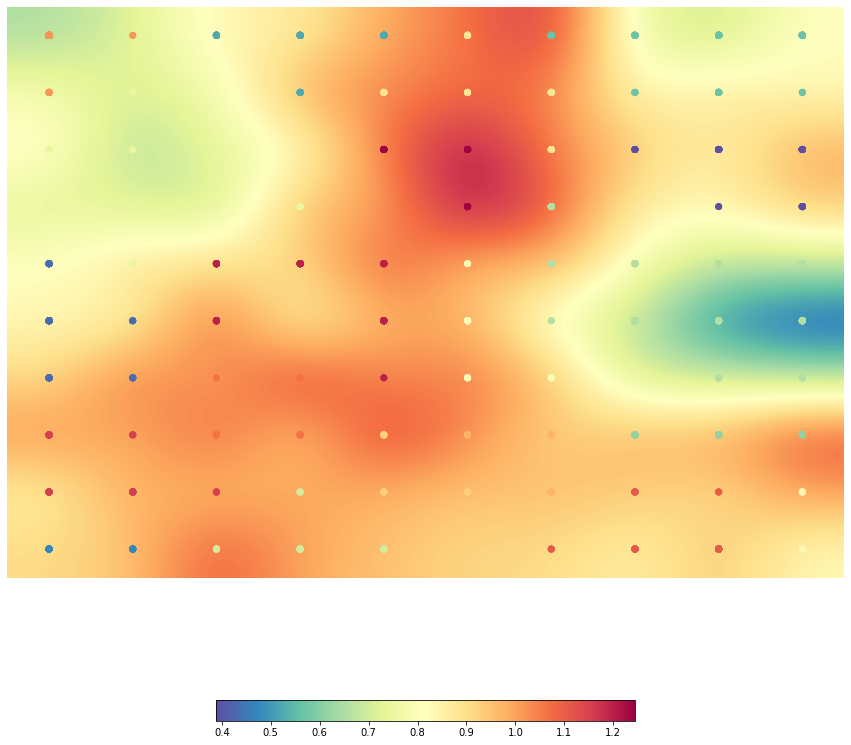

In [ ]:
somo.view_umatrix(bestmatches=True,figsize=(15,15),colorbar=True)
plt.show()

Βλέπουμε ότι η ομαδοποίηση των δεδομένων στον παραπάνω χάρτη δεν ήταν πολύ καλή, καθώς δεν έχουν σχηματιστεί πολλές μπλε περιοχές. Για τον λόγο αυτό, στην συνέχεια θα αυξήσουμε τους νευρώνες του SOM, και κατ' επέκταση και τα clusters για την ομαδοποίηση τους, ώστε να βελτιστοποιήσουμε τα αποτελέσματα μας.

In [ ]:
print('Print clusters variable\n')
print(somo.clusters)

Print clusters variable

[[14 14  3  3  3 11  4  4  4  4]
 [14  8  3  3 11 11 11  4  4  4]
 [ 8  8  8  8 19 19 11  0  0  0]
 [ 8  8  8  8  8 19  6  6  0  0]
 [ 1  8 18 18 18  9  6  6  6  6]
 [ 1  1 18 18 18  9  6  6  6  6]
 [ 1  1 15 15 18  9  9  6  6  6]
 [17 17 15 15 12 13 13  5  5  5]
 [17 17 17  7 12 12 13 16 16 10]
 [ 2  2  7  7  7 12 16 16 16 10]]


In [ ]:
print('(Cluster,Number of neurons)')
cluster, neurons = np.unique(somo.clusters,return_counts=True)
sort = np.argsort(neurons)
l1 = list(cluster[sort])
l2 = list(neurons[sort])
print(list(zip(l1,l2)))

(Cluster,Number of neurons)
[(2, 2), (10, 2), (19, 3), (14, 3), (13, 3), (5, 3), (15, 4), (12, 4), (9, 4), (7, 4), (11, 5), (3, 5), (1, 5), (16, 5), (17, 5), (0, 5), (18, 7), (4, 7), (8, 11), (6, 13)]



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [ ]:
def print_categories_stats(IDs,show = True):
  sort_categories = []
  for i in IDs:  
    # Χωρίζουμε τις συμβολοσειρές για τις κατηγορίες ταινιών στο ","
    genres = categories[i][0].split(',')  
    for j in range(0,len(genres)):   
      # Διώχνουμε τα κενά - whitespaces 
      genres[j]=genres[j].strip(" ").replace('"','')

    # Προσθήκη των κατηγοριών της ταινίας στην συνολική λίστα
    sort_categories.extend(genres) 

  # Μετράμε την συχνότητητα μοναδικών ετικετών των κατηγοριών  
  values, quantity = np.unique(sort_categories,return_counts=True) 

  # Ταξινόμηση σε φθίνουσα σειρά
  sort = np.argsort(-quantity) 

  values = values[sort]
  quantity = quantity[sort]

  data = list(zip(values,quantity))

  report = pd.DataFrame(data = data,columns=['Genre','Number of Movies'])
  
  if show:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.colheader_justify','right'):
      print(report)
  return report

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [ ]:
def print_cluster_neurons_movies_report(ID,model):
   bmu = []
   bmus,idxs = np.unique(model.bmus,axis=0,return_index=True)

   # Ψάχνουμε τις συντεταγμένες του χάρτη που διαμορφώνουν το cluster της εισόδου
   c=np.where(model.clusters == ID)
   d=np.column_stack(c)

   # Ελέγχουμε εάν τα bmu του cluster ανήκουν στον πίνακα με τα μοναδικά bmus
   # που υπολογίσαμε νωρίτερα
   for i in d:
     if i in bmus:
       bmu.append(i)
   return bmu

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

In [ ]:
def neuron_movies_report(neurons, model,show = True):
    idxs = []

    # Για τον κάθε νευρώνα, βρίσκουμε τα indexes των ταινιών,  
    # που ανήκουν σε αυτόν.
    for i in neurons:
      idx = np.where((model.bmus == i).all(axis=1))[0]
      idxs.extend(idx)
    idxs = list(map(int, idxs))
    # Εμφάνιση των κατηγοριών και της συχνότητας εμφάνισης της συγκεκριμένης 
    # κατηγορίας στον συγκεκριμένο νευρώνα
    categs = print_categories_stats(idxs,show)
    return categs,idxs

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```

Εμφανίζουμε την έξοδο για το cluster με **ID = 10**

In [ ]:
cluster_id = 10
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo)
neuron_report = neuron_movies_report(cluster_id_report,somo)

Overall Cluster Genre stats for Cluster with ID =  10 

                          Genre  Number of Movies
0                Romantic drama                87
1                  Romance Film                87
2                         Drama                87
3                  World cinema                49
4                       Musical                19
5                     Bollywood                19
6                  Period piece                13
7               Film adaptation                12
8                         Indie                10
9               Black-and-white                 7
10                     War film                 7
11                       Comedy                 7
12             Action/Adventure                 7
13                      Western                 6
14                    Melodrama                 5
15                Coming of age                 5
16              Romantic comedy                 5
17               Marriage Drama             


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## Βελτιστοποιημένο SOM

Για την συνέχεια της άσκησης, θα πειραματιστούμε με το corpus που προέκυψε από τα εμφυτεύματα του Google News dataset, καθώς όπως είδαμε και προηγουμένως παράγει τα πιο αξιόπιστα αποτελέσματα. 

Στην συνέχεια, θα δημιουργήσουμε έναν δεύτερο χάρτη 30x30, με 900 νευρώνες δηλαδή και θα τον εκπαιδεύσουμε εκ' νέου σε 100 εποχές. Τους 900 αυτούς νευρώνες θα τους ομαδοποιήσουμε σε 30 clusters. Επιπλέον, για να επιταγχύνουμε την διαδικασία εκπαίδευσης και ανάλυσης του SOM, θα χρησιμοποιήσουμε τα 2/5 του συνόλου των ταινιών που μας δίνονται.

In [ ]:
sub = build_final_set(best_corpus2,doc_limit=2000)

In [ ]:
somo1 = somoclu.Somoclu(n_columns=30,n_rows=30,compactsupport=False)
%time somo1.train(sub,epochs=100)

CPU times: user 7min 6s, sys: 1.44 s, total: 7min 7s
Wall time: 3min 50s


Όπως ήταν αναμενόμενο, η χρήση περισσότερων νευρώνων για τον σχηματισμό του SOM, απαιτεί και περισσότερο χρόνο για την ολοκλήρωση της διαδικασίας της εκπαίδευσης. Φαίνεται εκ' νέου, λοιπόν, το γιατί είναι προτιμότερη η χρήση ενός υποσυνόλου του σετ ταινιών που διαθέτουμε, για την δημιουργία και ανάλυση του αυτοοργανώμενου χάρτη μας.

In [ ]:
joblib.dump(somo1, 'somo1.pkl') 

In [ ]:
somo1 = joblib.load('somo1.pkl')

In [ ]:
somo1.cluster(KMeans(n_clusters=30,n_init=10,random_state = 42))

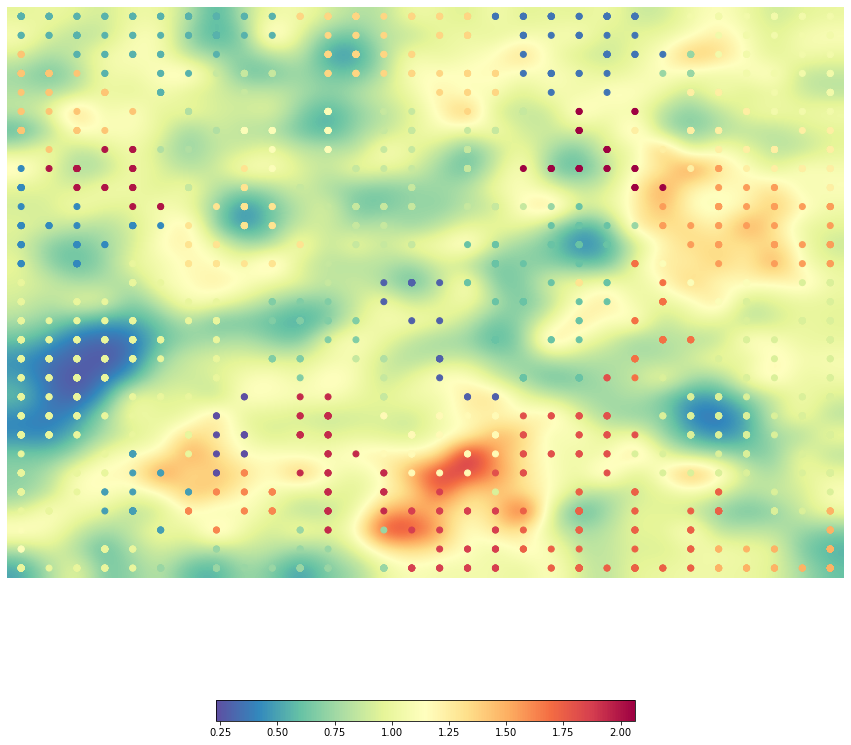

In [ ]:
somo1.view_umatrix(bestmatches=True,figsize=(15,15),colorbar=True)
plt.show()

In [ ]:
print('Print clusters variable\n')
cl = somo1.clusters
np.set_printoptions(linewidth=np.inf) # Το χρησιμοποιούμε για να φανεί ολόκληρος ο 30x30 πίνακας των clusters
for i in range(30):
  print(cl[i],end='')
  print()

Print clusters variable

[ 5  5  5  5  5  5  5  5  5  5 18 18 18 18 18 18 18  2  2  2  2  2  2  2 13 13 13 13 13 13]
[ 5  5  5  5  5  5  5  5  5  5 18 18 18 18 18 18 18  2  2  2  2  2  2  2 13 13 13 13 13 13]
[19 19  5  5  5  5  5  5  5 10 18 18 18 18 18 18 18 18  2  2  2  2  2  2  8 13 13 13 13 13]
[19 19 19  5  5  5  5 10 10 10 10 18 18 18 18 18 18 18  2  2  2  2  2  8  8 13 13 13 13 13]
[19 19 19 19  5  5  9 10 10 10 10 10 18 10 18 18 18 18 18  2  2  2 29 16 16 16 13 13 13 13]
[19 19 19 19 19  9  9  9 14 14 14 14 10 10 10 18 18 10 10 29 29 29 29 16 16 16 16 13 13 13]
[19 19 19 19 28  9  9  9 14 14 14 14 10 10 10 10 10 10 10 29 29 29 16 16 16 16 16 16 16 16]
[19 19 28 28 28  9  9  9 14 14 14 14 10 10 10 10 10 10 29 29 29 29 29 16 16 16 16 16 16 16]
[ 3 28 28 28 28 28  9 10 17 14 10 10 10 10 10 10 10 10 29 29 29 29 29 29 16 21 16 16 16 16]
[ 3  3 28 28 28 28 10 17 17 17 10 10 10 10 10 10 10 10 10 29 29 29 29 29 21 21 21 21 16 16]
[ 3  3  3 28 28 28 10 17 17 17 10 10 10 10 10 10 10 10 

In [ ]:
print('(Cluster, Number of neurons in cluster)')
cluster, neurons = np.unique(somo1.clusters,return_counts=True)
sort = np.argsort(neurons)
l1 = cluster[sort]
l2 = neurons[sort]
print(list(zip(l1,l2)))

(Cluster, Number of neurons in cluster)
[(0, 11), (22, 13), (9, 13), (4, 14), (20, 15), (28, 16), (26, 19), (15, 19), (23, 20), (19, 20), (3, 22), (14, 23), (1, 23), (7, 24), (8, 25), (25, 25), (29, 26), (27, 27), (17, 28), (2, 28), (13, 29), (16, 29), (21, 30), (5, 33), (18, 37), (24, 38), (6, 45), (11, 70), (10, 82), (12, 96)]


Θα εμφανίσουμε και για τον νέο χάρτη την έξοδο για το cluster με **ID = 10**

In [ ]:
cluster_id = 10
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1)

Overall Cluster Genre stats for Cluster with ID =  10 

                        Genre  Number of Movies
0                 Comedy film                43
1                 Documentary                42
2                       Drama                33
3                World cinema                20
4                     Musical                19
5                  Short Film                17
6                   Bollywood                13
7                       Indie                12
8                    Thriller                12
9             Black-and-white                 7
10          Culture & Society                 7
11                Silent film                 7
12              Crime Fiction                 7
13           Political cinema                 6
14                      Music                 6
15                  Biography                 6
16                   War film                 5
17              Social issues                 4
18                     Action   

### Σύγκριση των 2 παραγόμενων SOM

Στον δεύτερο αυτό χάρτη, βλέπουμε ότι οι μπλε και κόκκινες περιοχές του χάρτη είναι πολύ πιο εύκολα διαχωρίσιμες. Θυμίζουμε ότι σε περιοχές του χάρτη που ειναι χρωματισμένες με μπλε, οι αποστάσεις μεταξύ των νευρώνων είναι μικρές. Αντιθέτως στις κόκκινες, οι νευρώνες είναι πιο απομακρυσμένοι μεταξύ τους.



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

*   Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

Αρχικά, θα βρούμε στο σύνολο ταινιών που επεξεργαζόμαστε, ποιες ταινίες είναι αυτές που εμφανίζονται πιο συχνά και ποιες πιο σπάνια. Θα δούμε δηλαδή ποιες είναι εκείνες με την μεγαλύτερη πυκνότητα πιθανότητας στον χώρο εισόδου.

In [ ]:
mov_ids = np.arange(0,sub.shape[0],1)
movieset = print_categories_stats(mov_ids,show=False)

Οι 10 κατηγορίες ταινιών που εμφανίζονται πιο συχνά στο συγκεκριμένο σύνολο ταινιών φαίνονται στον παρακάτω πίνακα:

In [ ]:
display(movieset.head(10))

,Genre,Number of Movies
0,Drama,931
1,Comedy,457
2,Thriller,331
3,Romance Film,306
4,Action,286
5,World cinema,246
6,Crime Fiction,204
7,Horror,190
8,Action/Adventure,186
9,Black-and-white,178


Ορισμένες από τις κατηγορίες ταινιών που εμφανίζονται μονάχα μία φορές στο σύνολο ταινιών ειναι οι εξής:

In [ ]:
display(movieset.tail(10))

,Genre,Number of Movies
214,Extreme Sports,1
215,Rockumentary,1
216,Existentialism,1
217,Essay Film,1
218,Media Studies,1
219,Sci-Fi Thriller,1
220,Comedy Western,1
221,Social problem film,1
222,Splatter film,1
223,Sci-Fi Adventure,1


Θα εντοπίσουμε τώρα από πόσους νευρώνες ενεργοποιείται κάθε μία από τις παραπάνω κατηγορίες ταινιών

In [ ]:
genres = movieset['Genre']

# Δημιουργούμε έναν πίνακα με μέγεθος ίσο με τον αριθμό των διαφορετικών κατηγοριών ταινιών
nr_neurons = np.zeros(len(genres),dtype = np.uint16)
ubmus = np.unique(somo1.bmus,axis=0)

# Για κάθε έναν από τους νεωρώνες, βρίσκουμε τα είδη ταινιών που είναι συσχετισμένα με αυτόν
for u in ubmus:
  k = neuron_movies_report([tuple(u)],somo1,show=False)
  g = k[0]['Genre']

# Έπειτα αυξάνουμε κατά 1 την τιμή του στοιχείου του πίνακα nr_neurons, με index ίδιο με εκείνο
# της αντίστοιχης κατηγορίας ταινιών στο DataFrame movieset
  for i in range(len(g)):
    ix = np.where(movieset['Genre']==g[i])
    ix = int(ix[0])
    nr_neurons[ix] +=1

In [ ]:
# Προσθέτουμε τον αριθμό των νευρώνων που ενεργοποιούν την κάθε κατηγορία
# στο DataFrame

movieset['Number of Neurons'] = nr_neurons

In [ ]:
display(movieset.head(10))

,Genre,Number of Movies,Number of Neurons
0,Drama,931,252
1,Comedy,457,150
2,Thriller,331,123
3,Romance Film,306,95
4,Action,286,96
5,World cinema,246,100
6,Crime Fiction,204,90
7,Horror,190,74
8,Action/Adventure,186,77
9,Black-and-white,178,75


In [ ]:
display(movieset.tail(10))

,Genre,Number of Movies,Number of Neurons
214,Extreme Sports,1,1
215,Rockumentary,1,1
216,Existentialism,1,1
217,Essay Film,1,1
218,Media Studies,1,1
219,Sci-Fi Thriller,1,1
220,Comedy Western,1,1
221,Social problem film,1,1
222,Splatter film,1,1
223,Sci-Fi Adventure,1,1


Όπως ήταν αναμενόμενο, βλέπουμε ότι κατηγορίες ταινιών με πολλά δείγματα, όπως:

*   Δράματα
*   Κωμωδίες
*   Θρίλερ
*   Ρομαντικές ταινίες

τείνουν να αναπαριστώνται από περισσότερους νευρώνες.

Αντιθέτως, ταινίες όπως:

*   Western κωμωδίες
*   Ταινίες splater

οι οποίες περιέχουν πολύ λίγα δείγματα στο dataset μας, χρησιμοποιούν ελάχιστους νευρώνες για την αναπαράσταση τους (μονάχα 1 νευρώνα στην περίπτωση μας)



*   Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.



Για να μπορέσουμε να διακρίνουμε ποια από τα Clusters βρίσκονται κοντά μεταξύ τους ή απομακρυσμένα, θα ρίξουμε μία ματιά στον πίνακα somo1.clusters.

Clusters που βρίσκονται σε αντιδιαμετρικές περιοχές του χάρτη τείνουν να έχουν διαφορετικό περιεχόμενο. Χαρακτηριστικό παράδειγμα είναι το ζεύγος των clusters με ID = 5 και ID = 25. Το cluster με ID = 25, περιλαμβάνει κυρίως κωμικές ταινίες (ακόμα και animated ταινίες), οι οποίες προτείνονται για οικογένειες και παιδιά, ενώ το cluster με ID = 5, περιέχει δραματικές και ρομαντικές ταινίες, που απευθύονται κυρίως σε ενηλίκους.

Βέβαια, αυτό δε σημαίνει ότι Clusters τα οποία βρίσκονται μακριά το ένα από το άλλο, δεν θα διαθέτουν και δείγματα με παρόμοιο ύφος. Αυτό οφείλεται στο ότι είναι αδύνατη η τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.


In [ ]:
cluster_id = 5
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  5 



,Genre,Number of Movies
0,Drama,104
1,Romance Film,84
2,World cinema,81
3,Romantic drama,75
4,Musical,38
5,Bollywood,35
6,Comedy,18
7,Period piece,16
8,Film adaptation,15
9,Art film,12


In [ ]:
cluster_id = 25
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  25 



,Genre,Number of Movies
0,Comedy,51
1,Family Film,33
2,Short Film,23
3,Animation,16
4,Black-and-white,12
5,Slapstick,8
6,Romance Film,2
7,Holiday Film,2
8,Fantasy,2
9,Teen,2


*  Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Σε αντιστοιχία με πρίν, αναμένουμε γειτονικές ομάδες, να συσχετίζονται με ταινίες, οι οποίες έχουν παρόμοιο περιεχόμενο. Για τα clusters με ID = 1 και 6, βλέπουμε ότι εννοιολογικά σχεδόν ταυτίζονται, καθώς περιέχουν ταινίες κινουμένων σχεδίων, μικρής διάρκειας, και γενικά είναι κατάλληλες για παιδία και οικογένειες.

In [ ]:
cluster_id = 1
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  1 



,Genre,Number of Movies
0,Animation,26
1,Short Film,18
2,Comedy film,13
3,Children's,3
4,Family Film,3
5,Musical,3
6,Black-and-white,2
7,Comedy,2
8,Computer Animation,2
9,Anime,1


In [ ]:
cluster_id = 6
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  6 



,Genre,Number of Movies
0,Family Film,46
1,Animation,39
2,Short Film,21
3,Adventure,18
4,Fantasy,18
5,Comedy film,17
6,Children's/Family,6
7,Musical,5
8,Thriller,3
9,World cinema,3


*   Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Παράδειγμα cluster το οποίο δεν διαθέτει κάποιου είδους συνοχή όσον αφορά το είδος των ταινιών που περιέχει είναι εκείνο με ID = 11. Όπως μπορούμε να δούμε και στον επόμενο πίνακα, περιέχει ταινίες οι οποίες είναι κωμικές, δραματικές αλλά και ρομαντικές ταινίες ή ταινίες περιπέτειας. Πρόκειται μάλιστα για την τρίτη μεγαλύτερη ομάδα του χάρτη μας και συνορεύει με τα clusters:

*   20 --> περιλαμβάνει κυρίως κωμωδίες και ρομαντικές ταινίες
*   21 --> περιλαμβάνει κωμωδίες
*   24 --> περιλαμβάνει ταινίες δράσης και περιπέτειας

Συμπεραίνουμε ότι τέτοιού είδους clusters λειτουργούν σαν μεταβατικές περιοχές μεταξύ συνόλων ταινιών με διαφορετικό περιεχόμενο και ύφος.


In [ ]:
cluster_id = 11
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  11 



,Genre,Number of Movies
0,Comedy,135
1,Drama,100
2,Comedy-drama,39
3,Action,32
4,Romance Film,32
...,...,...
93,Prison,1
94,Revisionist Western,1
95,Comedy Western,1
96,Caper story,1


Για τον ίδιο ακριβώς λόγο, πολλές φορές παρατηρούμε ότι clusters τα οποία είναι γειτονικά μεταξύ τους, αντί να έχουν περιέχουν πανομοιότυπα πρότυπα όπως αναμένουμε, φαίνεται να μην έχουν κάποια τοπολογική συνάφεια. Τέτοιο παράδειγμα είναι το ζεύγος των clusters με ID = 10 και 17. 

Η 10η ομάδα περιέχει και αυτή με τη σειρά της μία μεγάλη γκάμα ταινιών (κυρίως κωμωδίες,ντοκιμαντέρ, musical και δραματικές ταινίες), ενώ από την άλλη το cluster 17 διαθέτει ταινίες δράσης και με πολεμικό περιεχόμενο.

In [ ]:
cluster_id = 10
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  10 



,Genre,Number of Movies
0,Comedy film,43
1,Documentary,42
2,Drama,33
3,World cinema,20
4,Musical,19
5,Short Film,17
6,Bollywood,13
7,Indie,12
8,Thriller,12
9,Black-and-white,7


In [ ]:
cluster_id = 17
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  17 



,Genre,Number of Movies
0,Silent film,10
1,War film,9
2,Western,9
3,Action/Adventure,6
4,Black-and-white,5
5,Mystery,4
6,Propaganda film,3
7,Costume drama,2
8,Documentary,2
9,Film noir,2


*   Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Γενικότερα, αξίζει να δώσουμε μεγαλύτερη έμφαση στα clusters τα οποία συγκεντρώνουν την πλειοψηφία των κυριότερων κατηγοριών ταινιών στο σετ ταινιών που επεξεργαζόμαστε. Συγκεκριμένα πολλά από αυτά τα clusters, βρίσκονται πολύ σε περιοχές του χάρτη, οι οποίες είναι χρωματισμένες με μπλε.
 
Υπενθυμίζουμε ότι τα πιο πολυπληθή είδη ταινιών είναι τα ακόλουθα:

In [ ]:
display(movieset.head(5))

,Genre,Number of Movies,Number of Neurons
0,Drama,931,252
1,Comedy,457,150
2,Thriller,331,123
3,Romance Film,306,95
4,Action,286,96


Το cluster με ID = 12, είναι πλούσιο σε ταινίες τρόμου και θρίλερ, πολλές εκ'των οποίων θεωρούνται και ταινίες δράσης, το οποίο είναι εύλογο, αν λάβει κανείς υπόψη του την φύση των ταινιών αυτών.

In [ ]:
cluster_id = 12
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  12 



,Genre,Number of Movies
0,Thriller,138
1,Horror,106
2,Action,71
3,Action/Adventure,60
4,Science Fiction,58
...,...,...
79,Plague,1
80,Melodrama,1
81,Chase Movie,1
82,Dystopia,1


Από την άλλη το cluster με ID = 18, περιέχει κυρίως δραματικές ταινίες.

In [ ]:
cluster_id = 18
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  18 



,Genre,Number of Movies
0,Drama,110
1,World cinema,43
2,Crime Fiction,10
3,Japanese Movies,9
4,Musical,8
...,...,...
59,Gangster Film,1
60,Historical drama,1
61,History,1
62,Comedy-drama,1


Ένα ακόμη πολύ σημαντικό cluster κρίνεται εκείνο με ID = 24 (καθώς και εκείνα γύρω από αυτό), όπου κυριαρχούν οι κωμικές ταινίες.

In [ ]:
cluster_id = 24
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  24 



,Genre,Number of Movies
0,Comedy,93
1,World cinema,15
2,Musical,9
3,Slapstick,8
4,Sex comedy,8
5,Horror,7
6,Black comedy,4
7,Cult,4
8,Mockumentary,3
9,Romance Film,3


Τέλος, έμφαση οφείλουμε να δώσουμε και στο cluster με ID = 5, το οποίο συγκεντρώνει μεγάλη μερίδα ρομαντικών ταινιών (προφανώς οι περισσότερες από τις ρομαντικές ταινίες χαρακτηρίζονται και ως δραματικές λόγω του σεναρίου τους και για αυτό υπάρχει επικάλυψη μεταξύ των 2 ειδών).

In [ ]:
cluster_id = 5
print('Overall Cluster Genre stats for Cluster with ID = ',cluster_id,'\n')
cluster_id_report = print_cluster_neurons_movies_report(cluster_id,somo1)
neuron_report = neuron_movies_report(cluster_id_report,somo1,show=False)
display(neuron_report[0])

Overall Cluster Genre stats for Cluster with ID =  5 



,Genre,Number of Movies
0,Drama,104
1,Romance Film,84
2,World cinema,81
3,Romantic drama,75
4,Musical,38
5,Bollywood,35
6,Comedy,18
7,Period piece,16
8,Film adaptation,15
9,Art film,12
